## Algorithms for phase retrieval
Implementations for 
* Phase diversity

*References:* <br>
- *Fienup [1982](http://ao.osa.org/abstract.cfm?URI=ao-21-15-2758)*<br>
- *Hanser+[2004](http://dx.doi.org/10.1111/j.0022-2720.2004.01393.x)*

** (continued from the other [notebook](https://nbviewer.jupyter.org/github/Mipanox/GPI_stuff/blob/master/notebooks/PR_ER_HIO.ipynb))**

In [1]:
%%capture
%load_ext autoreload
%autoreload 2+

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
exec(open('../codes/zernike.py'))
exec(open('../codes/pr.py'))
exec(open('../codes/util.py'))
%matplotlib inline

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18

---
## Input (true images)
Maximum 20% aberrations in both amplitude and phase. Randomly generated in Zernike coefficients (first 15)

In [75]:
coeff2 = np.random.random(15)
coeff1 = [0]*15#np.random.random(15)
P,P_,F,F_ = true_imgs(Npix=128,coeff1=coeff1,coeff2=coeff2,oversamp=2)

### 10% defocusing

In [76]:
defocus = 0.1
[P,P_,F,F_],[D,D_,Fd,F_d] = true_imgs_defocus(Npix=128,oversamp=2,
                                              coeff1=coeff1,
                                              coeff2=coeff2,
                                              defocus=defocus)

#### Oversampling
Zero-pad the pupil plane (object domain) image to for oversampling of 2 (Miao+[1998](http://dx.doi.org/10.1364/JOSAA.15.001662))

In [77]:
test = PR(pup=P,foc=F,oversamp=2)

In [78]:
test(foc_defoc=[F,Fd])

Make sure that the images look right

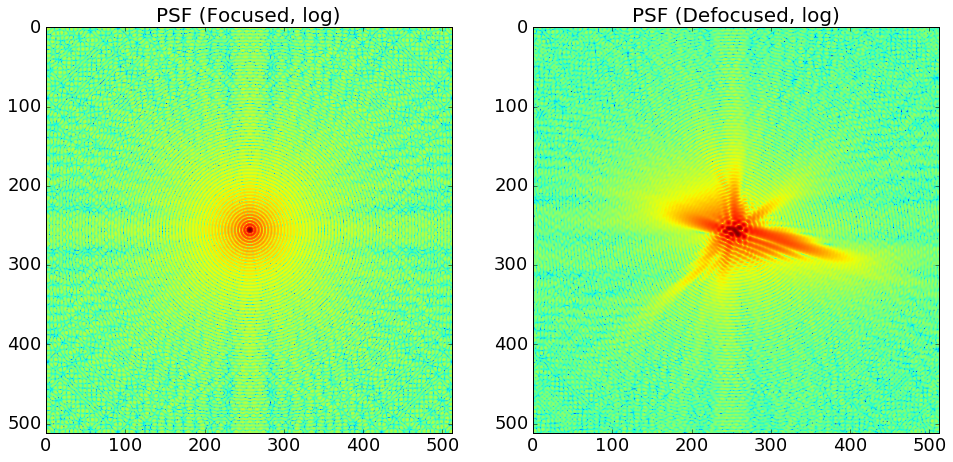

In [79]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(np.sqrt(test.foc_foc),norm=LogNorm()); plt.title('PSF (Focused, log)')
plt.subplot(122); plt.imshow(np.sqrt(test.foc_def),norm=LogNorm()); plt.title('PSF (Defocused, log)')

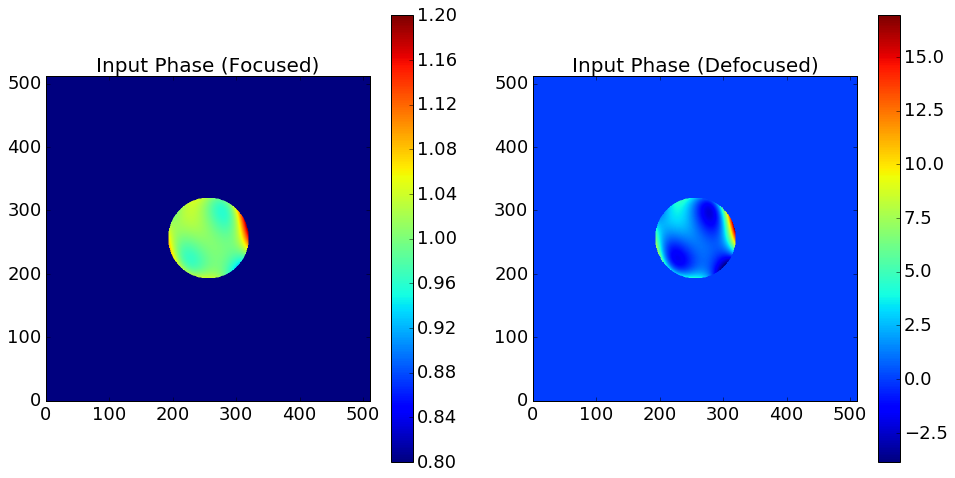

In [80]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(unwrap_phase(np.angle(P_)),origin='lower'); 
plt.colorbar(); plt.title('Input Phase (Focused)'); plt.clim(0.8,1.2)
plt.subplot(122); plt.imshow(unwrap_phase(np.angle(D_)),origin='lower'); 
plt.colorbar(); plt.title('Input Phase (Defocused)')

---
### Phase diversity (one defocused)

_500 iterations_

Caution: Pupil image is not used for constraints.


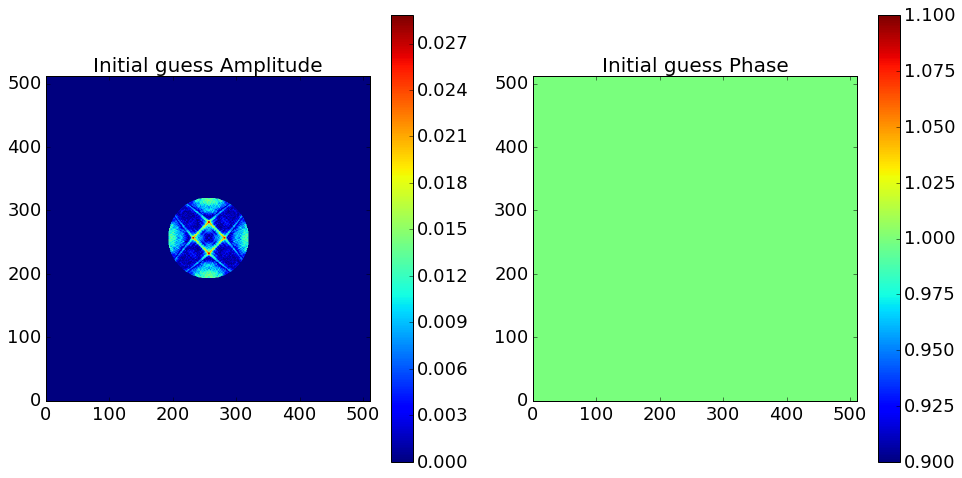

Current step                    : 100
Error (of focused Fourier plane): 6.56e-03
Current step                    : 200
Error (of focused Fourier plane): 6.46e-03
Current step                    : 300
Error (of focused Fourier plane): 6.37e-03
Current step                    : 400
Error (of focused Fourier plane): 6.35e-03
Current step                    : 500
Error (of focused Fourier plane): 6.35e-03
-----------------------
First iteration error: 1.37e-02
Final step : 500
Final Error: 6.35e-03


In [81]:
PD_ER_pup,PD_ER_foc,PD_ER_errlist,PD_ER_pup_proj = test.PD_ER(defocus=defocus,init='uniform')

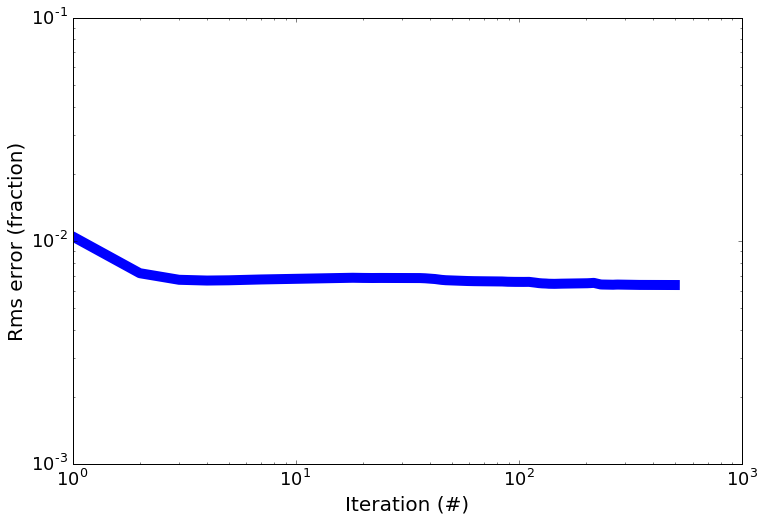

In [82]:
plot_errlist(PD_ER_errlist)

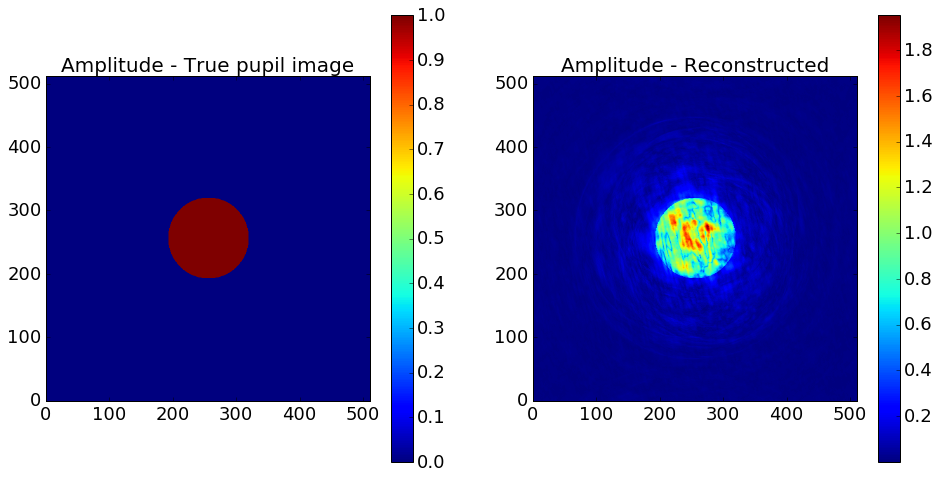

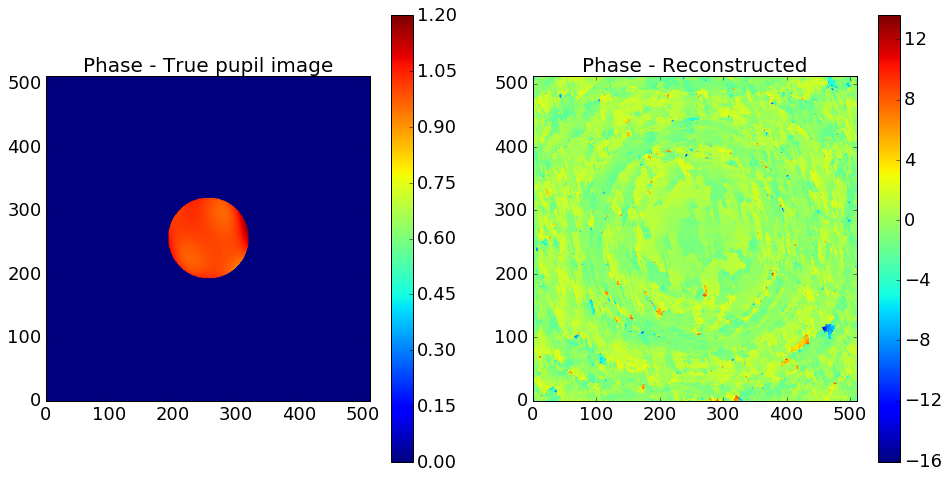

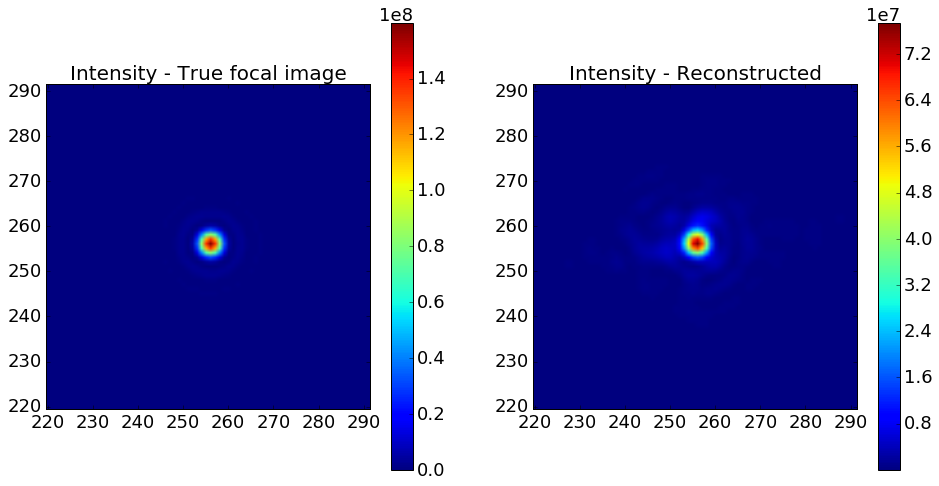

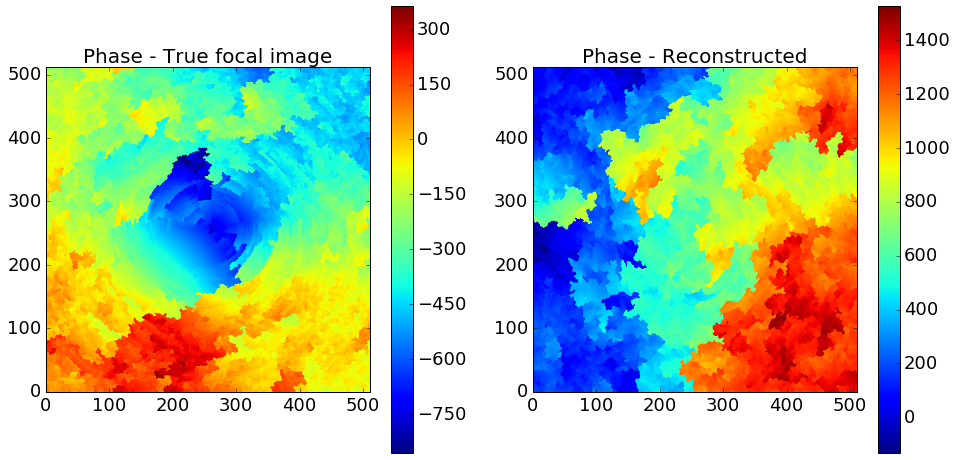

In [83]:
plot_recon(P_,F_,PD_ER_pup,PD_ER_foc)

#### Confined within the aperture

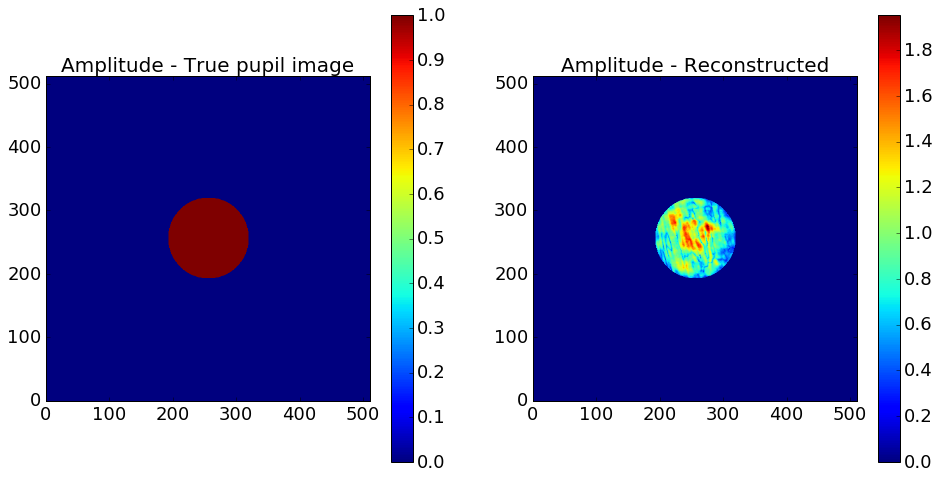

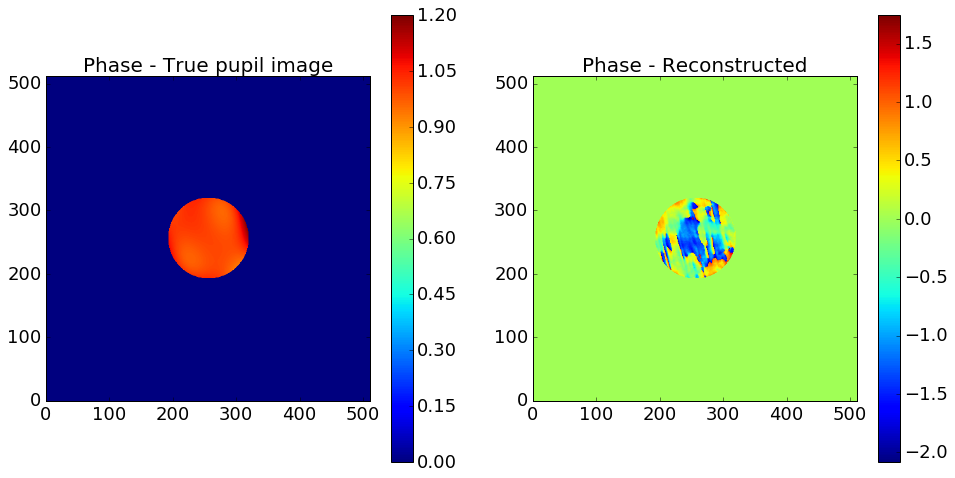

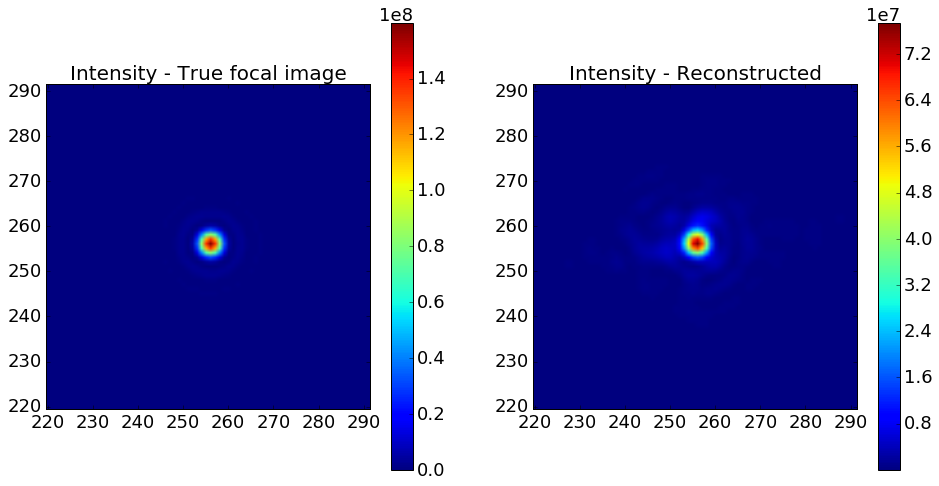

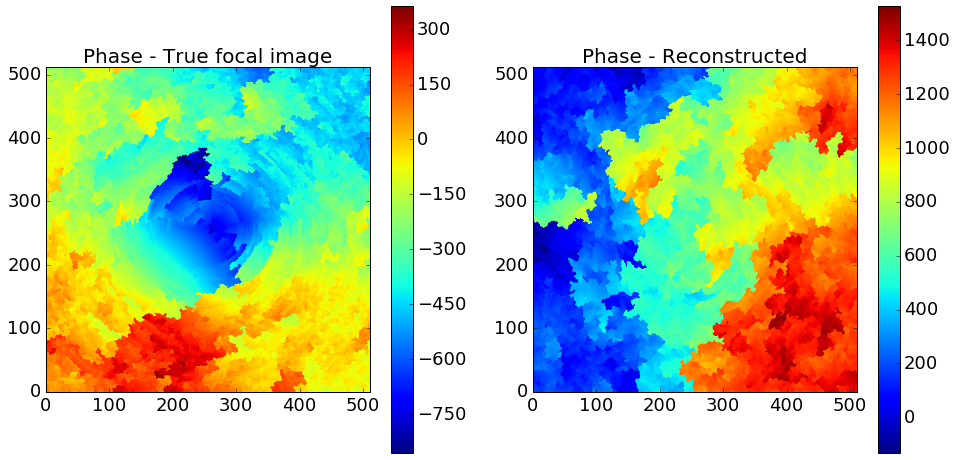

In [84]:
plot_recon(P_,F_,PD_ER_pup_proj,PD_ER_foc)

#### Crude masking: remove outer (high-f) part by applying a mask
To check if we can recover the "main" features...

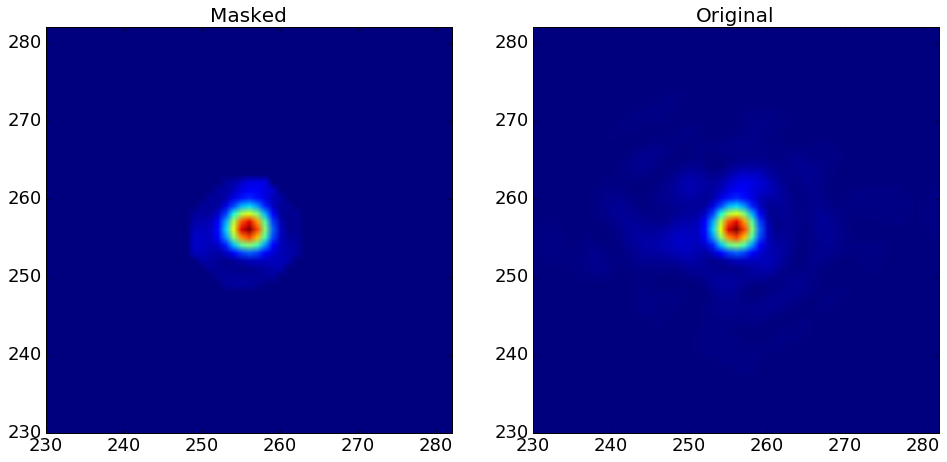

In [85]:
origin_int = abs(PD_ER_foc)**2
masked_int = ccmask(origin_int,radius=7)
masked_foc = ccmask(PD_ER_foc,radius=7)

plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(masked_int,origin='lower'); plt.xlim(230,282); plt.ylim(230,282); plt.title('Masked')
plt.subplot(122); plt.imshow(origin_int,origin='lower'); plt.xlim(230,282); plt.ylim(230,282); plt.title('Original')

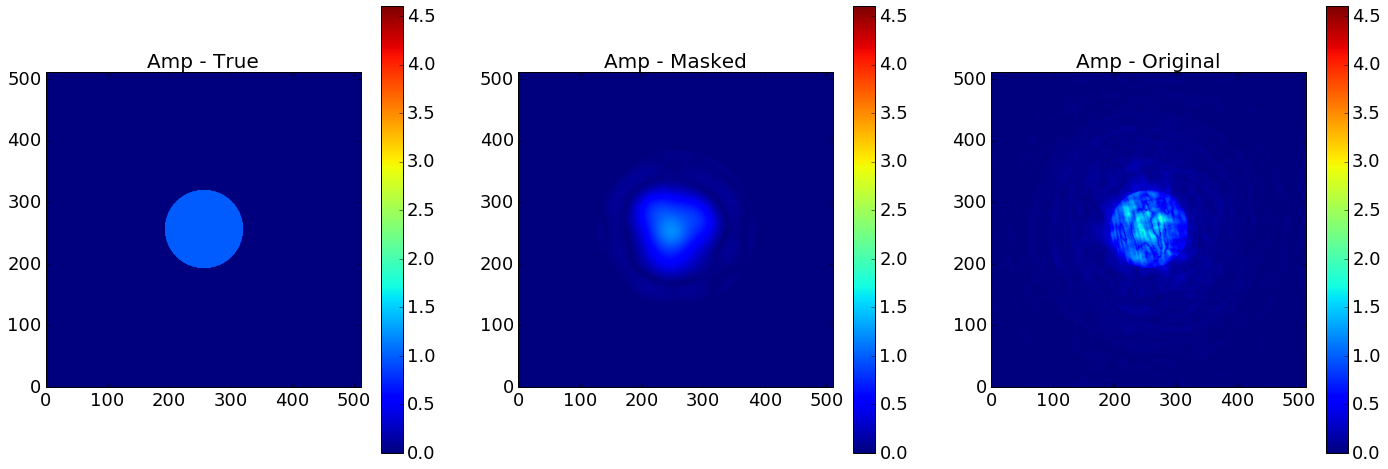

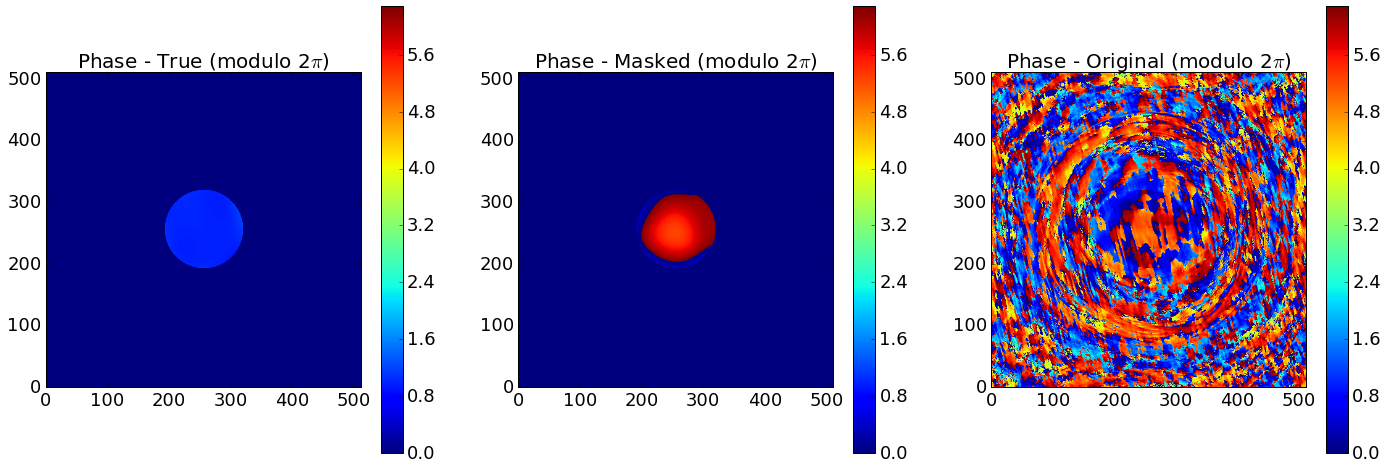

In [86]:
from numpy.fft import ifft2, ifftshift
new_pupil = ifft2(ifftshift(masked_foc))

plt.figure(figsize=(24,8))
plt.subplot(131); plt.imshow(abs(P_),origin='lower'); 
plt.title('Amp - True'); plt.colorbar(); plt.clim(0,4.6)
plt.subplot(132); plt.imshow(ccmask(abs(new_pupil),128),origin='lower'); 
plt.title('Amp - Masked'); plt.colorbar(); plt.clim(0,4.6)
plt.subplot(133); plt.imshow(abs(PD_ER_pup),origin='lower'); 
plt.title('Amp - Original'); plt.colorbar(); plt.clim(0,4.6)

plt.figure(figsize=(24,8))
plt.subplot(131); plt.imshow(ccmask(np.mod(np.angle(P_),2*np.pi),radius=64),origin='lower'); 
plt.title('Phase - True (modulo 2$\pi$)'); plt.colorbar(); plt.clim(0,2*np.pi)
plt.subplot(132); plt.imshow(ccmask(np.mod(np.angle(new_pupil),2*np.pi),radius=64),origin='lower'); 
plt.title('Phase - Masked (modulo 2$\pi$)'); plt.colorbar(); plt.clim(0,2*np.pi)
plt.subplot(133); plt.imshow(np.mod(np.angle(PD_ER_pup),2*np.pi),origin='lower'); 
plt.title('Phase - Original (modulo 2$\pi$)'); plt.colorbar(); plt.clim(0,2*np.pi)

Possible explanations for bad performance: running into the common ER local minimum when the defocusing is too small and/or should run even more iterations

---
### 10x defocusing
... and another set of true images (no amplitude aberration)

In [3]:
coeff2 = [0,1,0,0,0,1,2,0,2,1.5,2,0,0,0,0]
coeff1 = [0]*15 #np.random.random(15)
P,P_,F,F_ = true_imgs(Npix=128,coeff1=coeff1,coeff2=coeff2,oversamp=2)

In [4]:
defocus = 10
[P10,P_10,F10,F_10],[D10,D_10,Fd10,F_d10] = true_imgs_defocus(Npix=128,oversamp=2,
                                              coeff1=coeff1,
                                              coeff2=coeff2,
                                              defocus=defocus)

In [5]:
test10 = PR(pup=P10,foc=F10,oversamp=2)
test10(foc_defoc=[F10,Fd10])

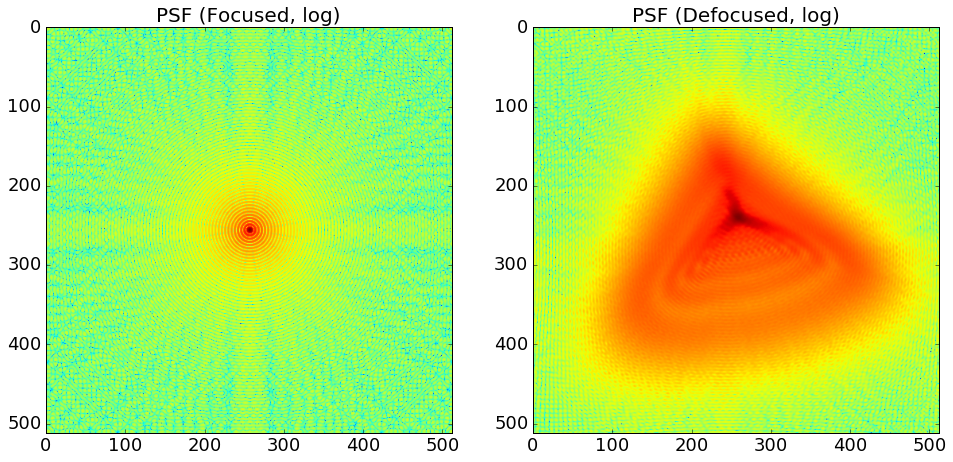

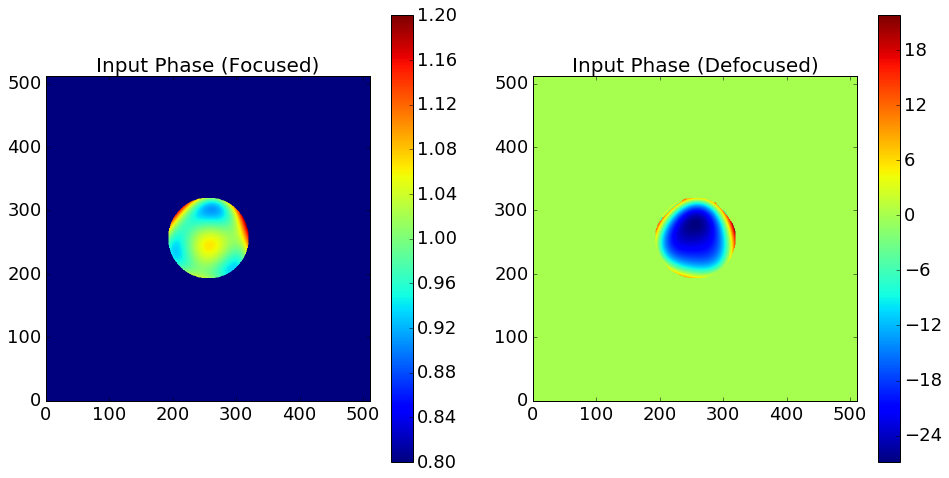

In [6]:
plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(np.sqrt(test10.foc_foc),norm=LogNorm()); plt.title('PSF (Focused, log)')
plt.subplot(122); plt.imshow(np.sqrt(test10.foc_def),norm=LogNorm()); plt.title('PSF (Defocused, log)')

plt.figure(figsize=(16,8))
plt.subplot(121); plt.imshow(unwrap_phase(np.angle(P_10)),origin='lower'); 
plt.colorbar(); plt.title('Input Phase (Focused)'); plt.clim(0.8,1.2)
plt.subplot(122); plt.imshow(unwrap_phase(np.angle(D_10)),origin='lower'); 
plt.colorbar(); plt.title('Input Phase (Defocused)')

#### 1000 iterations and random initial guess

Caution: Pupil image is not used for constraints.


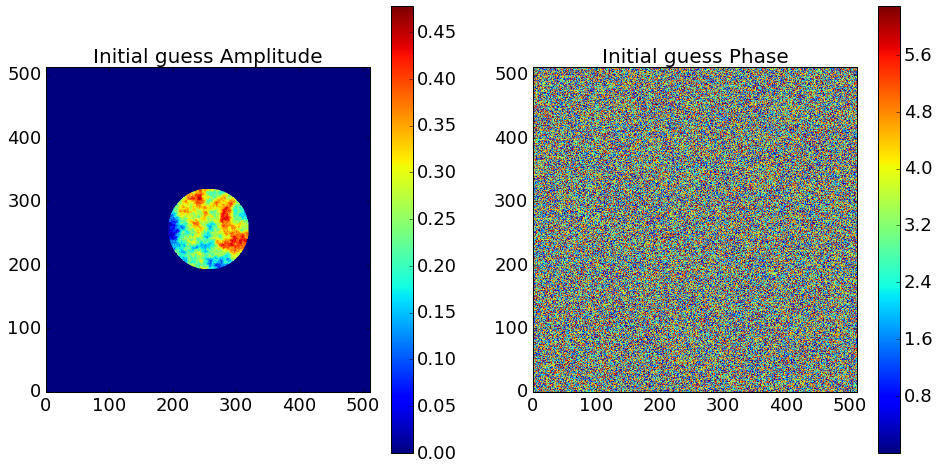

Current step                    : 100
Error (of focused Fourier plane): 3.91e-03
Current step                    : 200
Error (of focused Fourier plane): 3.93e-03
Current step                    : 300
Error (of focused Fourier plane): 3.92e-03
Current step                    : 400
Error (of focused Fourier plane): 3.95e-03
Current step                    : 500
Error (of focused Fourier plane): 3.95e-03
Current step                    : 600
Error (of focused Fourier plane): 3.97e-03
Current step                    : 700
Error (of focused Fourier plane): 3.95e-03
Current step                    : 800
Error (of focused Fourier plane): 3.95e-03
Current step                    : 900
Error (of focused Fourier plane): 3.99e-03
Current step                    : 1000
Error (of focused Fourier plane): 3.95e-03
-----------------------
First iteration error: 1.03e-02
Final step : 1000
Final Error: 3.95e-03


In [8]:
PD_ER_pup10, \
PD_ER_foc10, \
PD_ER_errlist10, \
PD_ER_pup10_proj, \
PD_ER_errpuplist10 = test10.PD_ER(defocus=defocus,init='random',iterlim=1000)

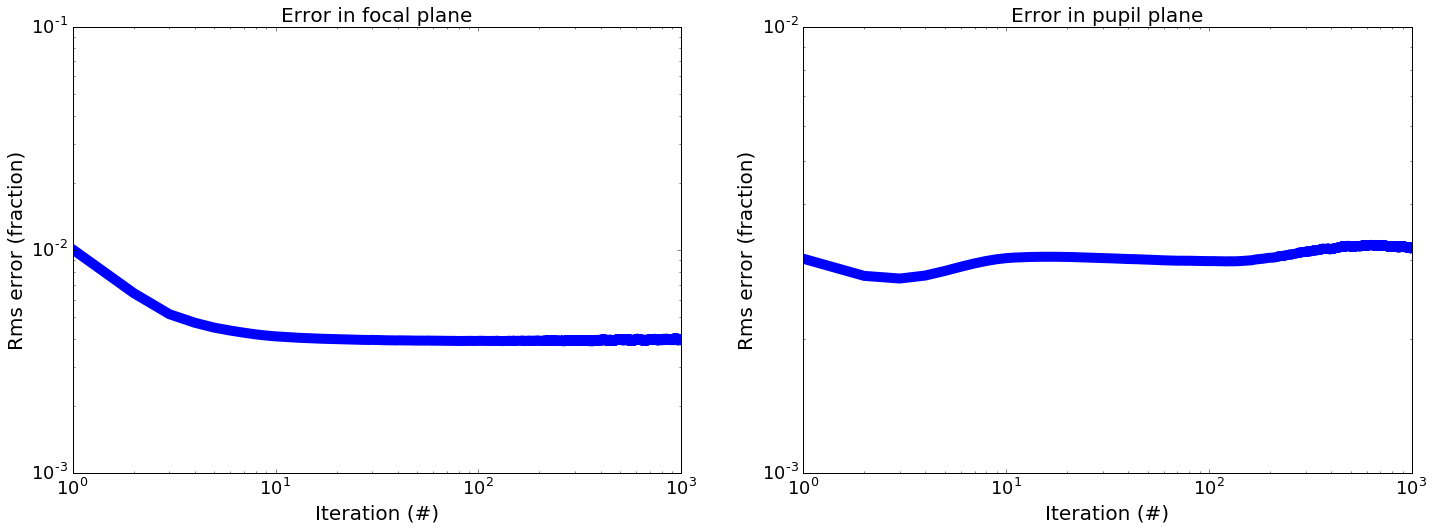

In [9]:
plot_errlist(PD_ER_errlist10,PD_ER_errpuplist10)

1000 iterations might be too many. The apparent minimum has been reached almost instantly (<100 iterations)

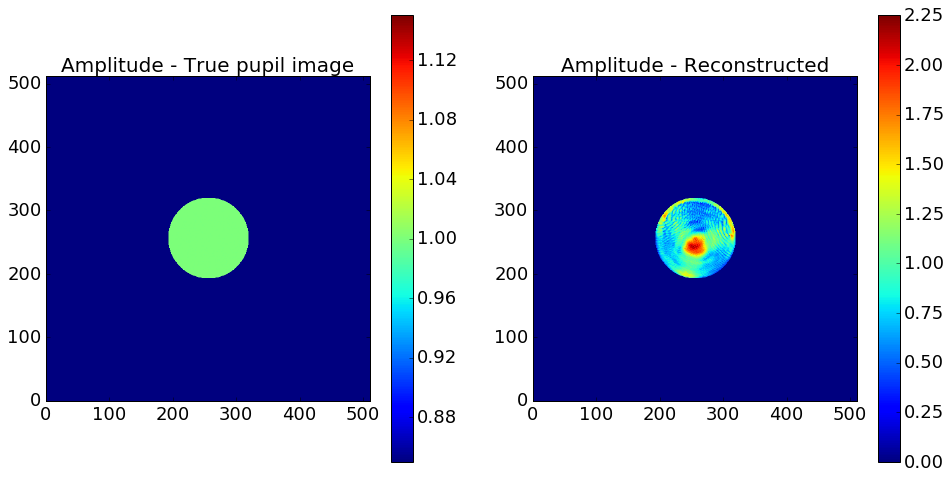

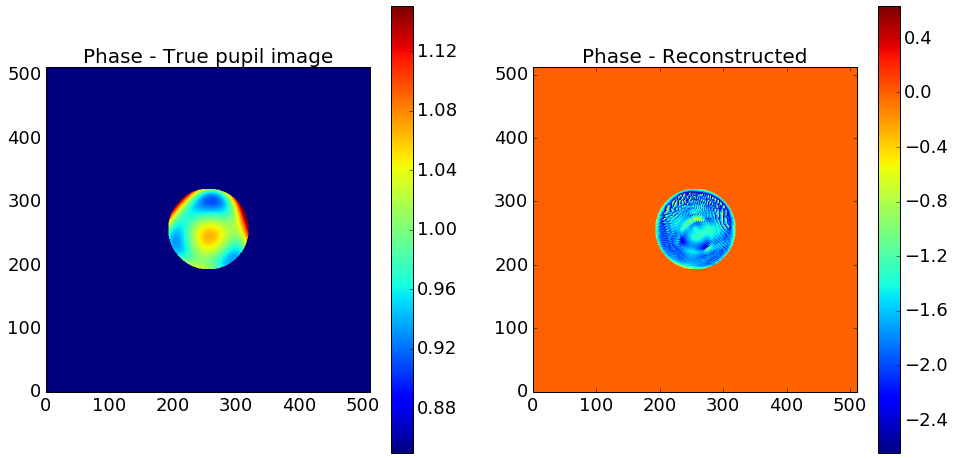

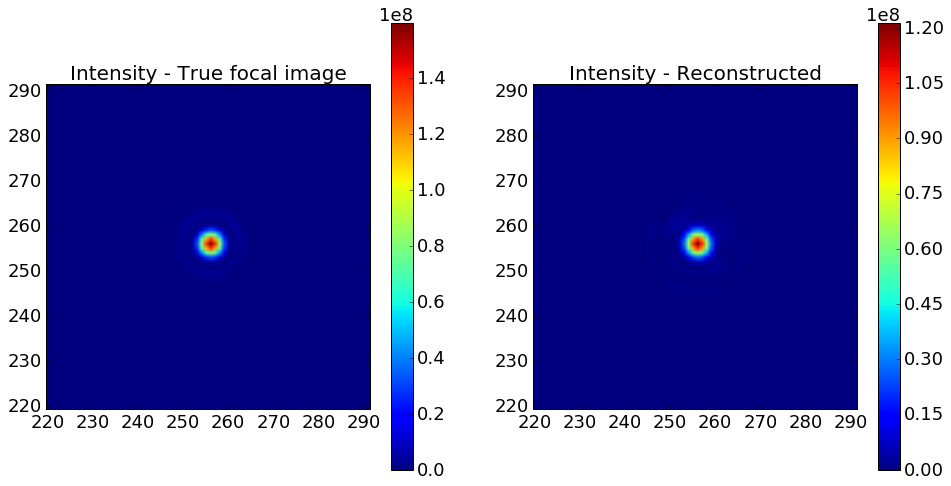

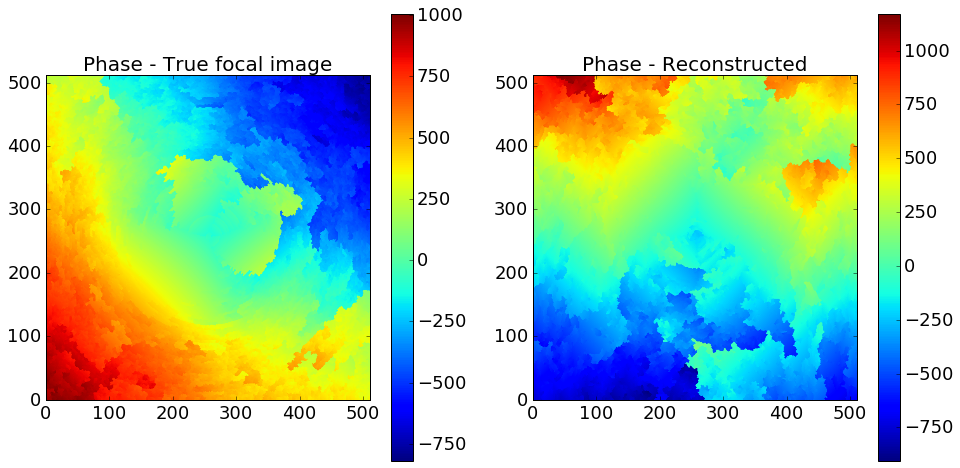

In [10]:
plot_recon(P_10,F_10,PD_ER_pup10_proj,PD_ER_foc10,max_abrAmp=0.15,max_abrPha=0.15)

Ripples...

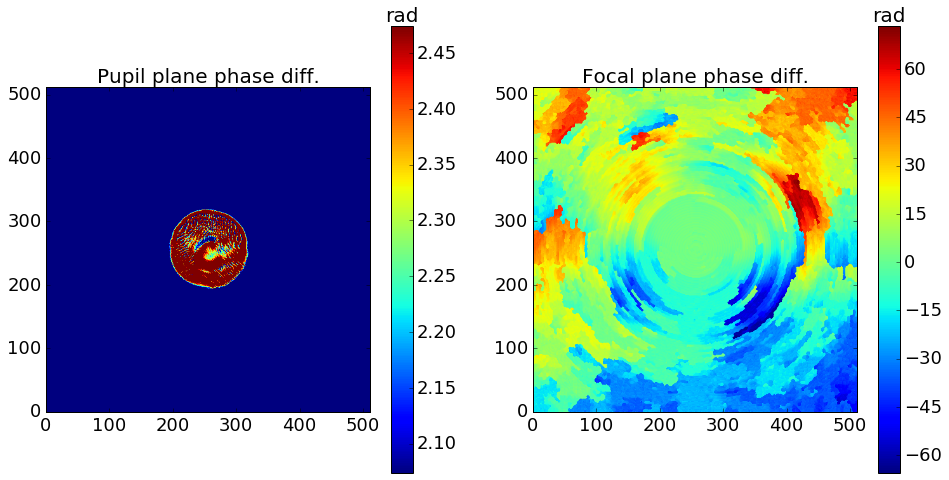

In [80]:
plot_phase_residual(P_10,F_10,PD_ER_pup10_proj,PD_ER_foc10)

Some "jumps" could not be get rid of. But roughly we're having good recoveries! Next steps would be to remove the high-frequency features that may destroy the overall patterns when noises are present.

#### How about 200 iterations?

Caution: Pupil image is not used for constraints.


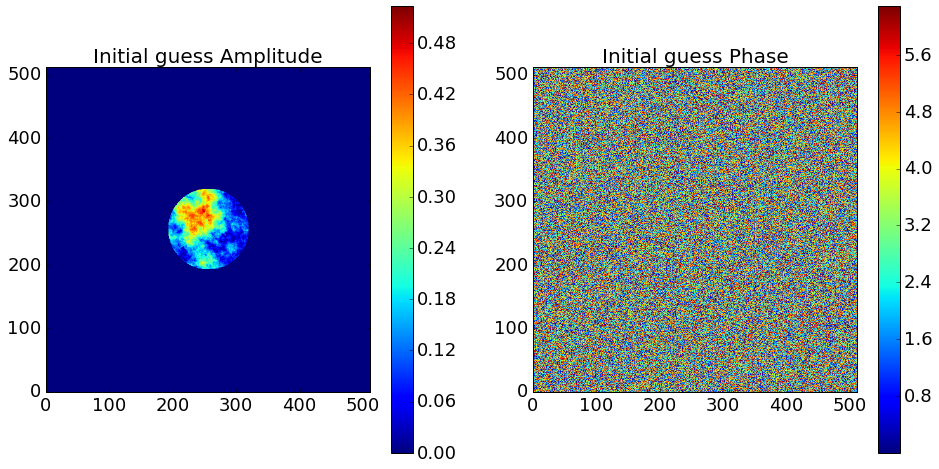

Current step                    : 100
Error (of focused Fourier plane): 2.86e-03
Current step                    : 200
Error (of focused Fourier plane): 2.86e-03
-----------------------
First iteration error: 1.11e-02
Final step : 200
Final Error: 2.86e-03


In [25]:
PD_ER_pup10, \
PD_ER_foc10, \
PD_ER_errlist10, \
PD_ER_pup10_proj, \
PD_ER_errpuplist10 = test10.PD_ER(defocus=defocus,init='random',iterlim=200)

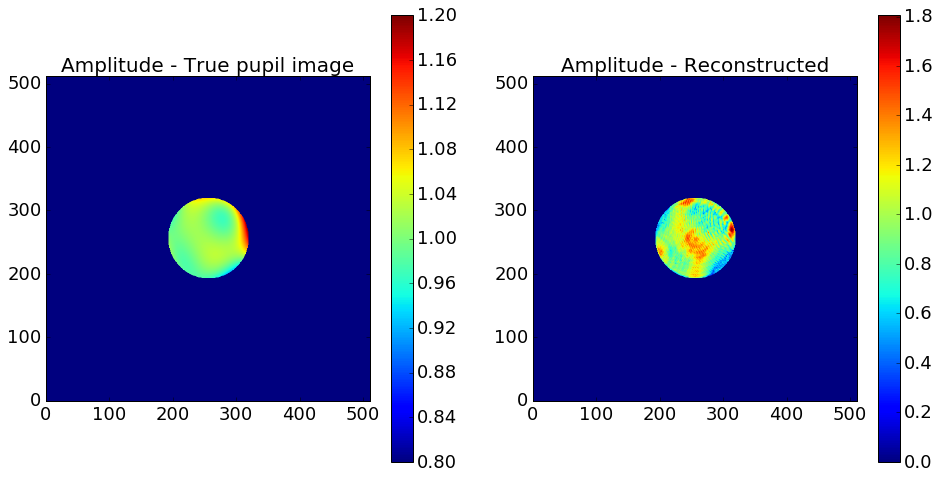

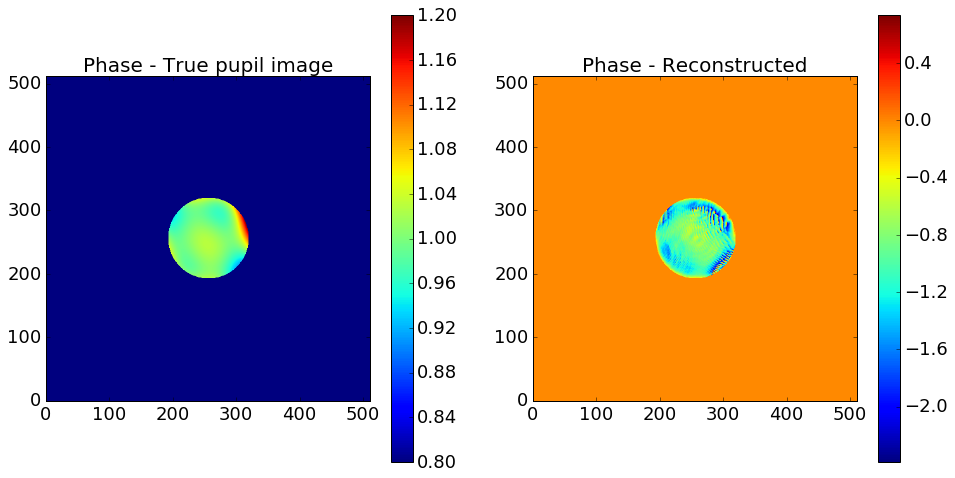

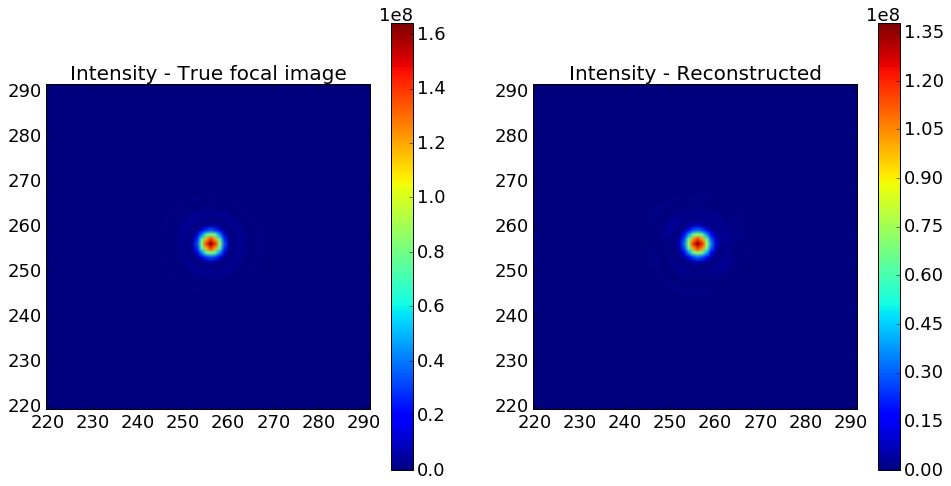

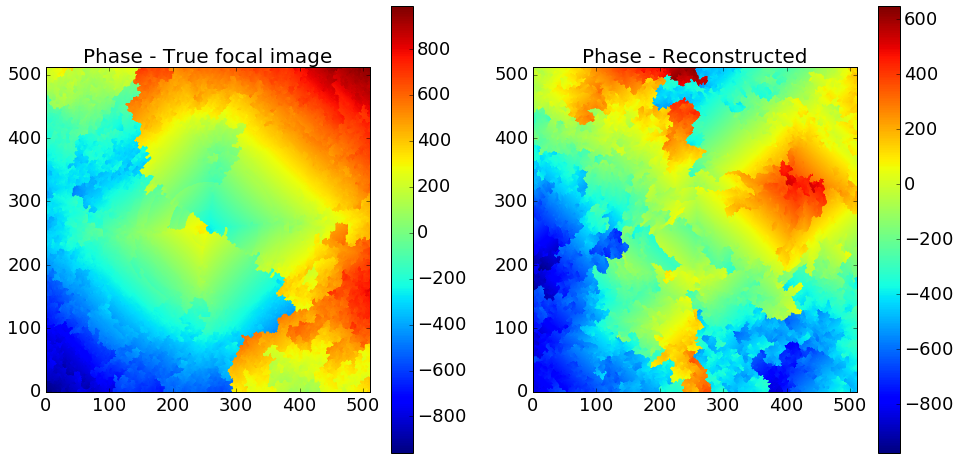

In [28]:
plot_recon(P_10,F_10,PD_ER_pup10_proj,PD_ER_foc10)

Not significantly different. What's causing those ripples? Insufficient oversampling? floating point error? Indecent choice of degree of decousing?

### Larger aberrations

In [5]:
coeff2 = np.random.random(15)
coeff1 = np.random.random(15)

defocus = 10

[P1,P_1,F1,F_1], \
[D1,D_1,Fd1,F_d1] = true_imgs_defocus(Npix=128,oversamp=2,
                                      coeff1=coeff1,
                                      coeff2=coeff2,
                                      defocus=defocus,
                                      max_aberA=1.,max_aberP=1.)

In [6]:
test1 = PR(pup=P1,foc=F1,oversamp=2)
test1(foc_defoc=[F1,Fd1])

Caution: Pupil image is not used for constraints.


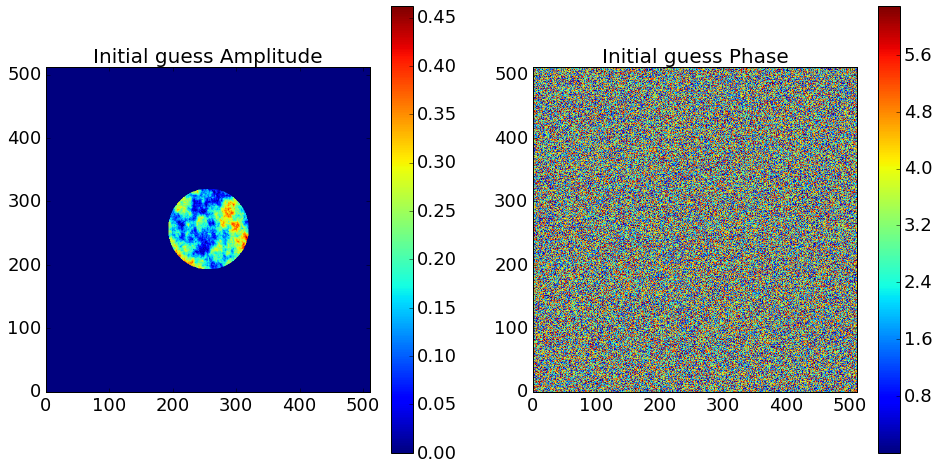

Current step                    : 100
Error (of focused Fourier plane): 2.57e-03
Current step                    : 200
Error (of focused Fourier plane): 2.56e-03
Current step                    : 300
Error (of focused Fourier plane): 2.56e-03
Current step                    : 400
Error (of focused Fourier plane): 2.56e-03
Current step                    : 500
Error (of focused Fourier plane): 2.58e-03
Current step                    : 600
Error (of focused Fourier plane): 2.59e-03
Current step                    : 700
Error (of focused Fourier plane): 2.60e-03
Current step                    : 800
Error (of focused Fourier plane): 2.59e-03
Current step                    : 900
Error (of focused Fourier plane): 2.60e-03
Current step                    : 1000
Error (of focused Fourier plane): 2.64e-03
-----------------------
First iteration error: 1.01e-02
Final step : 1000
Final Error: 2.64e-03


In [7]:
PD_ER_pup1, \
PD_ER_foc1, \
PD_ER_errlist1, \
PD_ER_pup1_proj = test1.PD_ER(defocus=defocus,init='random',iterlim=1000)

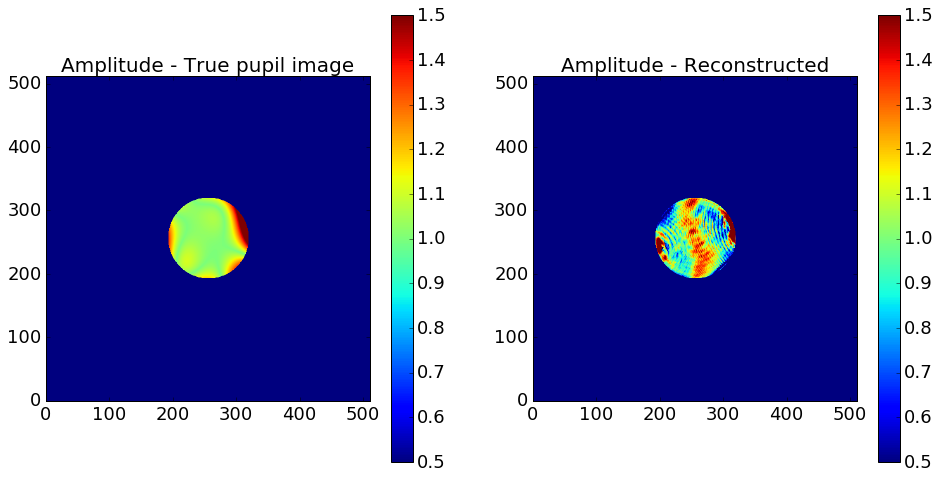

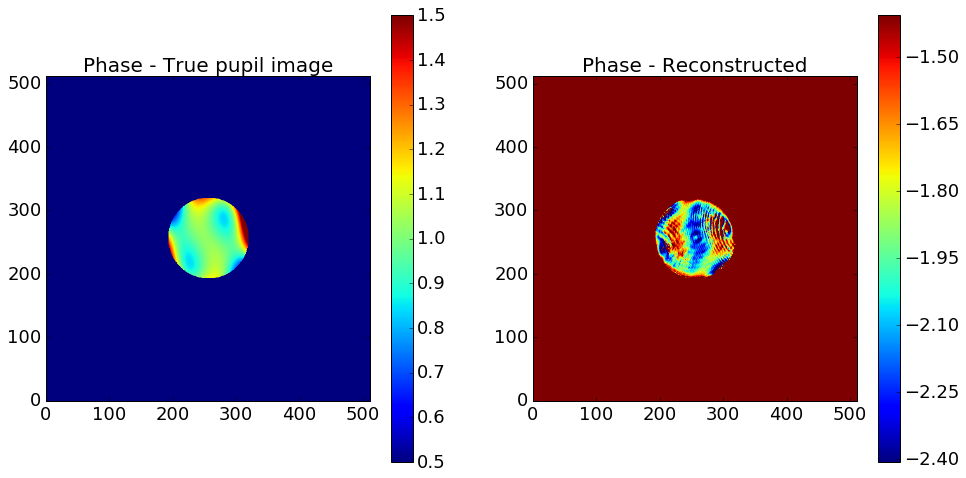

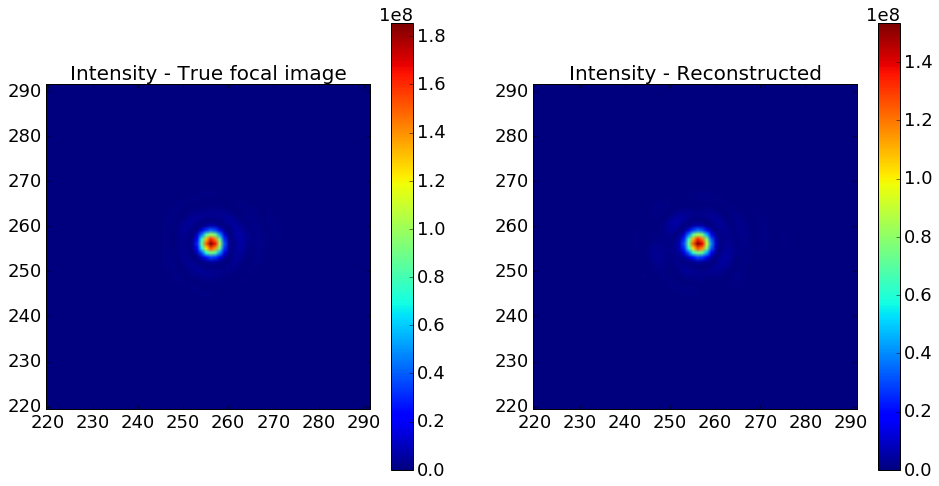

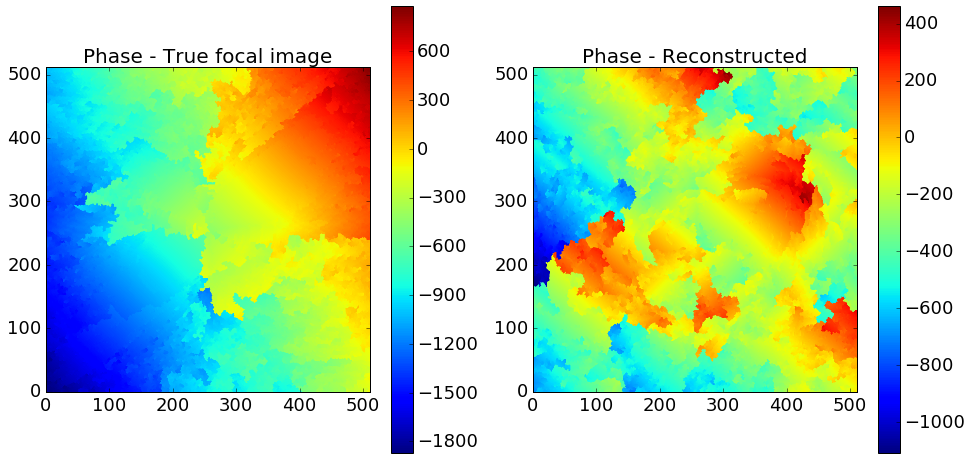

In [13]:
plot_recon(P_1,F_1,PD_ER_pup1_proj,PD_ER_foc1,recons_clim=True,
           max_abrAmp=.5,max_abrPha=.5)

---
## Sanity check
What if the initial guess happens to be "correct"?
_Should get back exactly the same true images_

In [33]:
coeff2 = np.random.random(15)
coeff1 = [0]*15
[P10,P_10,F10,F_10],[D10,D_10,Fd10,F_d10] = true_imgs_defocus(Npix=128,oversamp=2,
                                              coeff1=coeff1,
                                              coeff2=coeff2,
                                              defocus=defocus)

In [34]:
test10 = PR(pup=P10,foc=F10,oversamp=2)
test10(foc_defoc=[F10,Fd10])

Caution: Pupil image is not used for constraints.


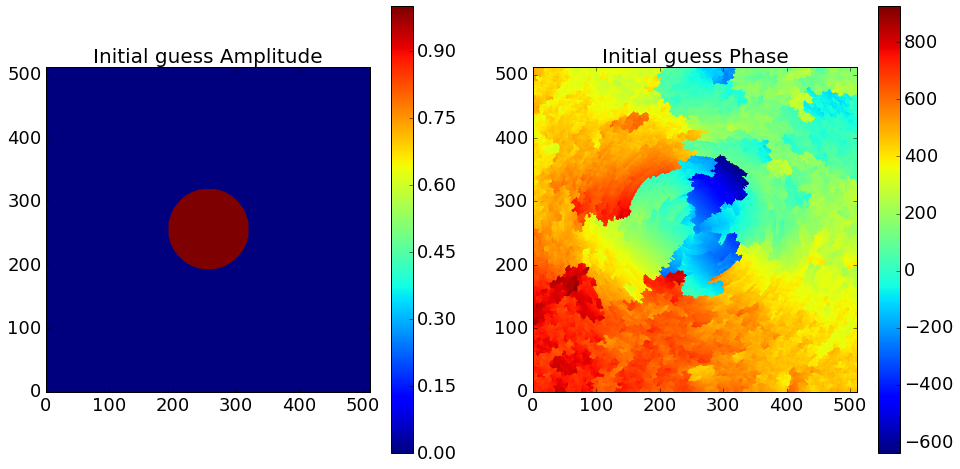

-----------------------
First iteration error: 7.80e-09
Final step : 1
Final Error: 7.80e-09


In [35]:
defocus=10
PD_ER_pup1, \
PD_ER_foc1, \
PD_ER_errlist1, \
PD_pup1_proj = test10.PD_ER(defocus=defocus,init='test',true_phasorP=F_10,true_phasorF=F_d10)

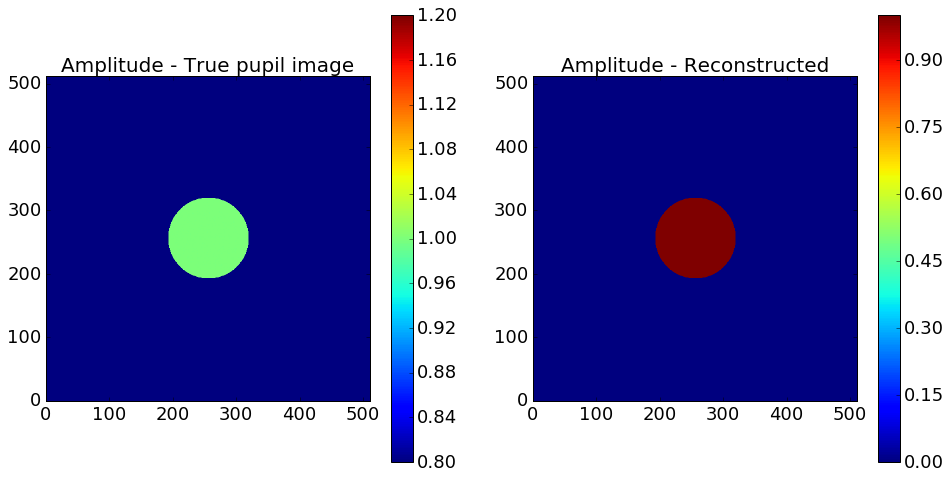

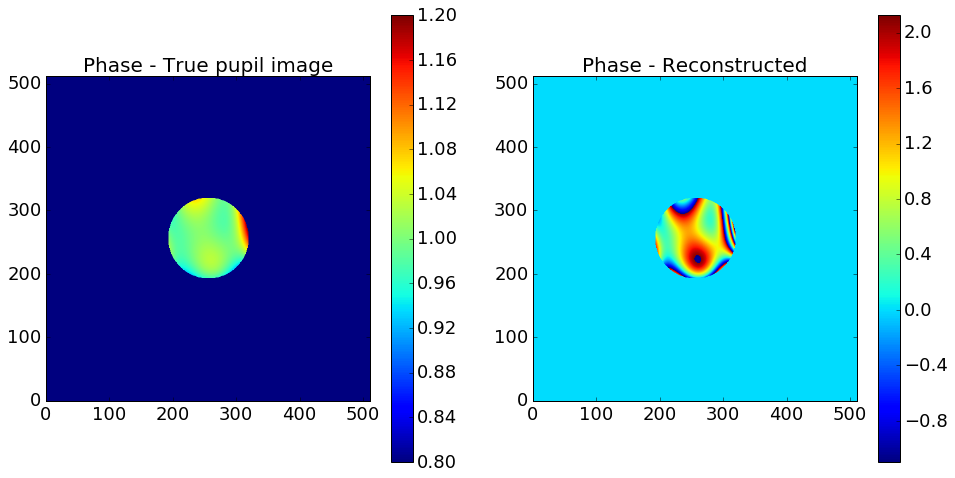

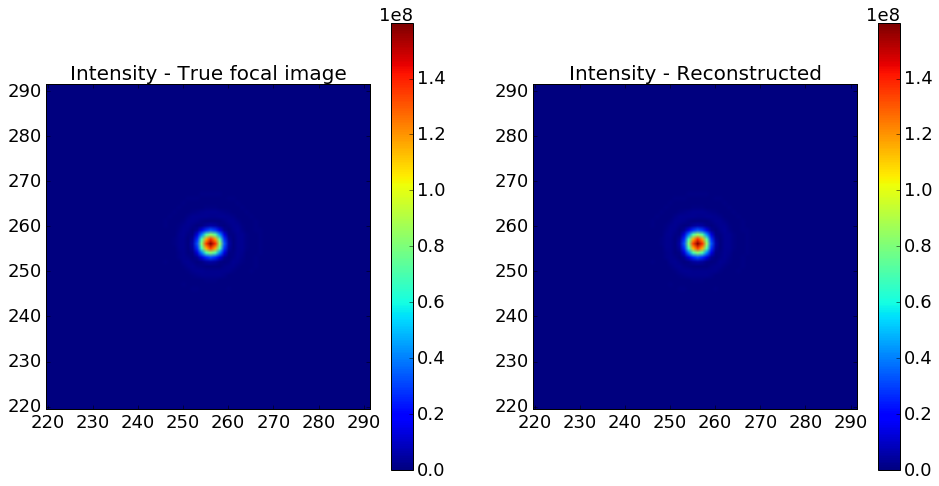

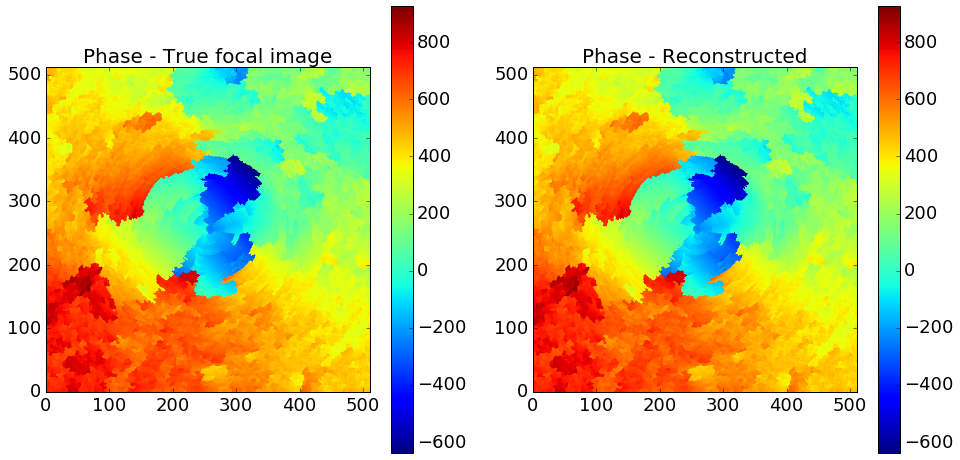

In [36]:
plot_recon(P_10,F_10,PD_pup1_proj,PD_ER_foc1)